## Digital filters in the Z domain

In this notebook, we're going to look into a new framework to understand and represent digital filters - through the Z-transform. This framework makes the derivation of transfer functions from linear difference equations of filters much easier, reveals a straightforward analysis of the filter’s stability through its poles and zeros, and a simple way to evaluate the filter’s frequency response. There are some nice geometric interpretations to digital filter design that we'll attempt highlight through interactive plots. 

In [ ]:
# Import the necessary packages as usual
%pip install ipympl
import numpy as np 
import scipy as sp
from scipy import signal
from  matplotlib import patches
from matplotlib.ticker import FormatStrFormatter
import io
from scipy.io import wavfile
from pyodide.http import pyfetch
from matplotlib import pyplot as plt
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
%matplotlib ipympl

# function for reading WAV files from a URL. Must be a RAW link, not GitHub HTML
speech_sample = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/F2.wav"
impulse_resp = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/IR1.wav"

async def read_wav_from_url(url):
    response = await pyfetch(url)
    wav_bytes = await response.bytes()  # get raw binary
    fs, data = wavfile.read(io.BytesIO(wav_bytes))

    # convert to float in [-1, 1]
    if np.issubdtype(data.dtype, np.integer):
        max_val = np.iinfo(data.dtype).max
        data = data.astype(np.float32) / max_val
    else:
        data = data.astype(np.float32)  # already float
    
    return data, fsb

### The Z-transform

The Z-transform of a discrete-time signal, $x[n]$ is defined as:

$$
\mathcal{Z}(x[n]) = X(z) = \sum_{n = -\infty}^{\infty} x[n]z^{-n}
$$

where $\mathcal{Z}(.)$ is the Z-transform operator and $z$ is some complex variable. For a discrete-time signal, $x[n]$, we will denote its Z-transform as $X(z)$ (and similarly for other discrete-time signals). The Z-transform essentially transforms a discrete sequence of values into a series with powers of $z$. For instance, the Z-transform of a discrete-time signal $x[n] = [1, 2, 3, 4]$ corresponding to indices $n=\{-1, 0, 1, 2\}$ is given by:

$$
X(z) = \sum_{n = -\infty}^{\infty} x[n]z^{-n} = \sum_{n = -1}^{2} x[n]z^{-n} = 1z^{1} + 2 + 3z^{-1} + 4z^{-2}
$$

### Z-transform properties

There are three important properties of the Z-transform that we will frequently use in digital filter analysis:

| Property    | Z-transform |
| -------- | ------- |
| LINEARITY  |  $\mathcal{Z}(ax[n] + by[n]) =  aX(z) + bY(z)$  (where $a$ and $b$ are constants).   |
| TIME-SHIFT |  $\mathcal{Z}(x[n-m]) = z^{-m}X(z)$     |
| CONVOLUTION    | $\mathcal{Z}(x[n] * y[n]) = X(z)Y(z)$    |


### Z-domain transfer function 

Recall that given an impulse response, $h[n]$ for a linear time-invariant (LTI) digital filter, the output is given by the convolution between $h[n]$ and an input signal, $x[n]$, i.e., $y[n] = h[n] * x[n]$, where $*$ denotes the convolution operator. If we were to take the Z-transform of this equation and make use of the convolution property, we would obtain:

$$
\begin{align}
\mathcal{Z}(y[n]) &= \mathcal{Z}(h[n] * x[n])\\
Y(z) &= H(z)X(z) \\
H(z) &= \frac{Y(z)}{X(z)}
\end{align}
$$

where $H(z)$ is the transfer function of the LTI digital filter in the Z-domain and is also equal to the Z-transform of the impulse response of the LTI filter, i.e.,

$$
H(z) = \frac{Y(z)}{X(z)} = \sum\limits_{n=-\infty}^{n=\infty} h[n] z^{-n}
$$

Recall that the general form of a $K^{th}$ order LTI digital filter in the discrete-time domain is given by

$$
y[n] = \sum_{k=0}^{K} b_{k} x[n-k] - \sum_{k=1}^{K} a_{k} y[n-k]
$$

where $a$ and $b$ are real-valued coefficients. Taking the Z-transform of this expression, making use of the time-shift property, and doing some simple re-arrangement yields the transfer function for the general form of a $K^{th}$ order LTI digital filter:

$$
\begin{align}
H(z) &= \frac{\sum\limits_{k=0}^{K} b_{k} z^{-k}} {1 + \sum\limits_{k=1}^{K} a_{k} z^{-k} }
    &= \frac{b_0 + b_1z^{-1} + b_2z^{-2} + \dots + b_Kz^{-K}}{1 + a_1z^{-1} + a_2z^{-2} + \dots + a_Kz^{-K}} 
\end{align}
$$

### Poles and Zeros

It can also be shown (but I'll not do that here) that this transfer function can be factorized into $K$ first-order terms (i.e., terms with only the power of $z^{-1}$) as follows:

$$
\begin{align}
H(z)  &= g \frac{(1-q_1z^{-1}) (1-q_2z^{-1}) \dots (1-q_Kz^{-1})   }{(1-p_1z^{-1}) (1-p_2z^{-1}) \dots (1-p_Kz^{-1})}\nonumber
\end{align}
$$

where:
- g is some scalar gain
- $q_k$ (for k = 1, 2, …, K) are called the **zeros** of the filter, since if $z = q_k$, then $H(z)=0$ (the numerator of $H(z)$ goes to zero)
- $p_k$ (for k = 1, 2, .. K) are called the **poles** of the system, if $z = p_k$, then $1/H(z)=0$ (the denominator of $H(z)$ goes to zero). 

Since $z$ is a complex variable, it means that the poles and zeros are, in general, complex-valued and hence can be plotted in the complex plane (imaginary vs. real values). We can also express the poles and zeros in terms of a magnitude and phase, which allows for a convenient/useful geometric interpretation. It turns out that the criterion for stability of LTI digital filters is that **all of the poles are within the unit circle**, i.e., the magnitude of all of the poles must be less than 1. The poles and zeros also appear in complex conjugate pairs, which is a consequence of the filter coefficients $a_k$ and $b_k$ being real-valued (we'll also show this later on).

### A simple example

To make sense of this pole-zero concept, let's consider a very simple 1st order filter with the following difference equation:

$$
y[n] = x[n] + a_1y[n-1]
$$

Taking the Z-transform and rearranging to obtain the transfer function yields:
$$
H(z) = \frac{1}{1 - a_1z^{-1}} 
$$

Upon comparing to the pole-zero factorised form as above, we can immediately identify a zero, $q_1 = 0$ and a pole, $p_1 = a_1$. The other way to obtain the poles and zeros of the transfer function is simply to multiply the expression by $z/z$:

$$
H(z) = \frac{z}{z - a_1} 
$$

from which we can see $H(z) = 0$ when $z=0$ and hence a zero, $q_1 = 0$, and $1/H(z) = 0$ when $z = a_1$, hence a pole, $p_1 = a_1$. 
In terms of magnitude of phase of the pole, in this case, its magnitude is $a_1$ and phase is zero. In the examples that follow, we'll look at examples of poles and zeros whose phases are non-zero. 

But let's get to the plot to understand how the position of the pole affects this first order filter. Below, you can move the slider to change the value of the pole, which is plotted on the complex plane (a pole-zero plot). Also plotted in the complex plane is the unit circle (radius = 1). Hence if the pole position extends beyond the unit circle, the filter goes unstable. And what do we mean by instability? Well on the right-hand plot, we also show the resulting output $y[n]$ from the difference equation to a unit impulse input. We can see that once the magnitude of the pole is greater than 1 (outside of the unit circle), the output grows in an unbounded manner! 

Move the slider to change the value of a1, and hence the pole position in the complex plane.


interactive(children=(FloatSlider(value=0.5, description='a1', max=1.2, min=0.1, step=0.01), Output()), _dom_c…

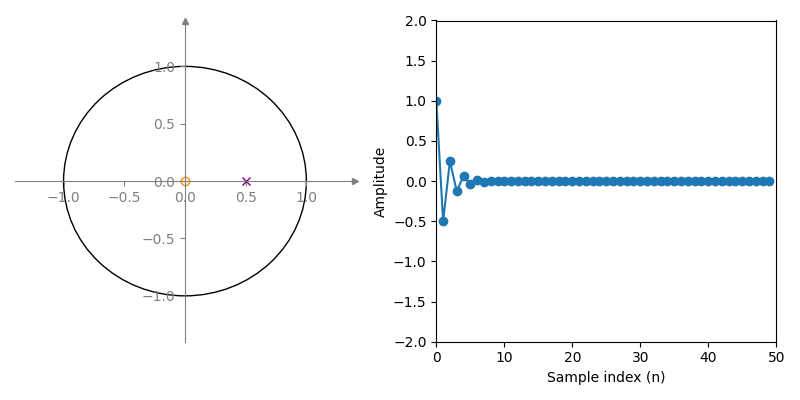

In [2]:
# Setting up the input/output signals
N = 50
n_idx = np.arange(0,N,1)
x = np.zeros(len(n_idx)); x[0] = 1
y = np.zeros(len(n_idx))



# PLOT
fig, axes = plt.subplots(1,2,figsize=(8,4))
pole_color = "purple"; zero_color = "darkorange"    
UnitCircle = patches.Circle((0.0, 0.0), radius=1,edgecolor="black",facecolor="none")

# # Unit Circle plot
axes[0].add_patch(UnitCircle) 
axes[0].set_xlim(-1.5,1.5)

# Poles + Zeros
p1, = axes[0].plot([], [], 'x',color=pole_color)
axes[0].plot(0, 0, 'o', color = zero_color, fillstyle="none")

#% Magnitude Plot
line, = axes[1].plot([], [],'-o')
axes[1].set_xlabel('Sample index (n)')
axes[1].set_ylabel('Amplitude')
axes[1].set_xlim([0,N])
axes[1].set_ylim(-2, 2)

# Changing around the axes (formatting stuff)
axes[0].xaxis.set_ticks_position('bottom')
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.label.set_color('grey')
axes[0].tick_params(axis='x', colors='grey')
axes[0].yaxis.label.set_color('grey')
axes[0].tick_params(axis='y', colors='grey')

axes[0].spines['left'].set_position('zero')
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_position('zero')
axes[0].spines['top'].set_visible(False)

axes[0].spines['left'].set_color('grey')
axes[0].spines['bottom'].set_color('grey')

# make arrows
axes[0].plot((1), (0), ls="", marker=">", ms=5, color="grey", transform=axes[0].get_yaxis_transform(), clip_on=False)
axes[0].plot((0), (1), ls="", marker="^", ms=5, color="grey",transform=axes[0].get_xaxis_transform(), clip_on=False)
axes[0].set_xlim(-1.4, 1.4)
axes[0].set_ylim(-1.4, 1.4)
plt.tight_layout()


# Create the interactive plot
def update(a1 = 0.5):

    # computing yn
    for n in n_idx:
        if n==0:
            y[n] = x[n]
        else:
            y[n] = x[n] - a1*y[n-1]

    p1.set_data([a1], [0])
    line.set_data([n_idx], [y])
    fig.canvas.draw_idle()

print('Move the slider to change the value of a1, and hence the pole position in the complex plane.')
interact(update, a1 = (0.1,1.2,0.01)); 




### Frequency response of digital filters

Okay we've seen how poles and zeros can impact the time domain filter outputs, but what about the frequency response? Let's recall our Z-transform definition:

$$
\mathcal{Z}(x[n]) = X(z) = \sum_{n = -\infty}^{\infty} x[n]z^{-n}
$$

If we make the substitution $z = e^{j \omega T_s}$, where we recall that $\omega = 2 \pi f$ is the angular frequency (rad/s), $f$ is the frequency in Hz, and $T_s = 1/f_s$ is the sampling period (s) with $f_s$ the sampling frequency (Hz), then we obtain:

$$
X(e^{j \omega T_s}) = \sum_{n = -\infty}^{\infty} x[n]e^{-j \omega T_s n} = \sum_{n = -\infty}^{\infty} x[n]e^{-j 2 \pi f T_s n}
$$

which is exactly the [discrete-time Fourier transform](https://randyaliased.github.io/acspjbook/main/fundamental/07_DFT.html#discrete-time-fourier-transform-dtft) we previously encountered! Hence by simply substituting $z = e^{j \omega T_s}$ into the transfer function, $H(z)$ of a filter, we can obtain its frequency response (i.e., its magnitude and phase across frequency). But what does $e^{j \omega T_s}$ correspond to? Well it's a complex number with magnitude of 1 and a phase of $\omega T_s$, hence for a fixed sampling frequency, as frequency increases, the phase $\omega T_s$ increases and we will essentially trace out the unit circle (magnitude one). Hence an evaluation of the frequency response corresponds to evaluation the Z-transform on the unit circle! We'll see a visual of this shortly, but let's firstly look at the relation again to poles and zeros.


Let's consider our pole-zero factorised form of $H(z)$, substitute $z = e^{j \omega T_s}$, and do some simple factorization:

$$
\begin{align}
H(z)  &= g \frac{(1-q_1z^{-1}) (1-q_2z^{-1}) \dots (1-q_Kz^{-1})   }{(1-p_1z^{-1}) (1-p_2z^{-1}) \dots (1-p_Kz^{-1})}\nonumber \\
\nonumber \\
H(e^{j \omega T_s})  &= g \frac{(1-q_1e^{-j \omega T_s}) (1-q_2e^{-j \omega T_s}) \dots (1-q_Ke^{-j \omega T_s})   }{(1-p_1e^{-j \omega T_s}) (1-p_2e^{-j \omega T_s}) \dots (1-p_Ke^{-j \omega T_s})}\nonumber \\
\nonumber \\
 &= g \frac{e^{-j K \omega T_s}}{e^{-j K \omega T_s}} \frac{(e^{j \omega T_s}-q_1) (e^{j \omega T_s}-q_2) \dots (e^{j \omega T_s}-q_K)   }{(e^{j \omega T_s}-p_1) (e^{j \omega T_s}-p_2) \dots (e^{j \omega T_s}-p_K)}\nonumber \\
\\
 &= g \frac{(e^{j \omega T_s}-q_1) (e^{j \omega T_s}-q_2) \dots (e^{j \omega T_s}-q_K)   }{(e^{j \omega T_s}-p_1) (e^{j \omega T_s}-p_2) \dots (e^{j \omega T_s}-p_K)}\nonumber 
\end{align}
$$

What we can observe is that all of the factorised terms are a difference between $e^{j \omega T_s}$ and the respective pole or zero. Now let's take the magnitude of the expression. Recall the rule that $|AB| = |A| |B|$ (where $|.|$ refers to taking the magnitude of a complex number):

$$
\begin{align}
|H(e^{j \omega T_s}) | & = \left| g \frac{(e^{j \omega T_s}-q_1) (e^{j \omega T_s}-q_2) \dots (e^{j \omega T_s}-q_K)   }{(e^{j \omega T_s}-p_1) (e^{j \omega T_s}-p_2) \dots (e^{j \omega T_s}-p_K)} \right| \nonumber \\
\\ \nonumber
& =  g \frac{|(e^{j \omega T_s}-q_1) (e^{j \omega T_s}-q_2) \dots (e^{j \omega T_s}-q_K)  | }{|(e^{j \omega T_s}-p_1) (e^{j \omega T_s}-p_2) \dots (e^{j \omega T_s}-p_K)|}  \nonumber \\
\\ \nonumber
&= g \frac{|(e^{j \omega T_s}-q_1)| . |(e^{j \omega T_s}-q_2)| \dots |(e^{j \omega T_s}-q_K)|   }{|(e^{j \omega T_s}-p_1)| . |(e^{j \omega T_s}-p_2)| \dots |(e^{j \omega T_s}-p_K)|} 
\end{align}
$$

This equation brings us to a really nice geometric interpretation. Each of the individual magnitude terms correspond to the length of a vector drawn from the respective zero or pole to the point $e^{j \omega T_s}$. Hence, we can interpret the Magnitude response of the filter at any frequency $f$ (or $\omega$) as the ratio:

$$
|H(e^{j \omega T_s}) | = \frac{\text{product of lengths of vectors drawn from zeros to point $e^{j \omega T_s}$}}{\text{product of lengths of vectors drawn from poles to point $e^{j \omega T_s}$}}
$$

For the phase response, we take the angle as follows (recalling the rule that $\angle (AB/C) = \angle A + \angle B - \angle C$ ):

$$
\begin{align}
 \angle H(e^{j \omega T_s})  &= \angle g \frac{(e^{j \omega T_s}-q_1) (e^{j \omega T_s}-q_2) \dots (e^{j \omega T_s}-q_K)   }{(e^{j \omega T_s}-p_1) (e^{j \omega T_s}-p_2) \dots (e^{j \omega T_s}-p_K)}\nonumber \\
 \nonumber \\ 
    &= \angle g +  \angle(e^{j \omega T_s}-q_1) + \angle (e^{j \omega T_s}-q_2) + \dots + \angle (e^{j \omega T_s}-q_K) \nonumber \\
    &= - \angle (e^{j \omega T_s}-p_1) - \angle (e^{j \omega T_s}-p_2)- \dots - \angle (e^{j \omega T_s}-p_K)\nonumber 
\end{align}
$$

Hence we can interpret the Phase response of the filter at any frequency $f$ (or $\omega$) as:

$$
\begin{align}
\angle H(e^{j \omega T_s}) &= \text{offset} + \text{sum of angles of vectors drawn from zeros to point $e^{j \omega T_s}$} \nonumber \\
      &= − \text{sum of angles of vectors drawn from poles to point $e^{j \omega T_s}$}
\end{align}
$$

### A two-pole, two-zero example

Let's get some more intuition for this through an interactive plot. We'll just look at the Magnitude response for a simple two-pole, two-zero filter as follows:

$$
H(z)  =  \frac{(1-q_1z^{-1}) (1-q_2z^{-1})}{(1-p_1z^{-1}) (1-p_2z^{-1})}\nonumber \\
$$

for which the magnitude response will be:

$$
|H(e^{j\omega T_s})|  =  \frac{|(e^{j\omega T_s}- q_1)| . |(e^{j\omega T_s}- q_2)|}{|(e^{j\omega T_s}- p_1)| . |(e^{j\omega T_s}- p_2)|}\nonumber \\
$$

This expression already gives us a hint into this filter's frequency response by considering the lengths of vectors drawn from zeros to point $e^{j \omega T_s}$ and the lengths of vectors drawn from the poles to point $e^{j \omega T_s}$. For instance, the frequency at which the lengths of vector from the $p_1$ to point $e^{j \omega T_s}$ (i.e., the term $|(e^{j\omega T_s}- p_1)|$) is small, then we should expect $|H(e^{j\omega T_s})| $ to be large, indicative of a resonant boost. 

Let's see this in the following interactive plot, where the left-hand plot shows the complex plane with the unit circle, poles, zeros, and the distances from the zeros and poles to the point $e^{j \omega T_s}$ (dotted lines) as we increase frequency. On the right-hand plot, as we change the frequency, we can see the corresponding Magnitude response that is being traced out. 

It's important to keep in mind how the frequency in Hz relates to $\omega T_s$ (i.e., the phase of $e^{j \omega T_s}$). If we denote $\phi = \omega T_s$, and recall $\omega = 2 \pi f$, then it should be evident that the frequency, $f$ in Hz is given by:

$$
f = \frac{\phi}{2\pi T_s} = \frac{\phi f_s}{2\pi} 
$$

When $\phi = 0$, $f = 0$ Hz, and when $\phi = \pi$, $f = f_s/2$ Hz (Nyquist frequency), which explains why the spectrum repeats after $\phi = \pi$. 

Move the slider to evaluate the magnitude response for different frequencies (Hz)!
Sampling Frequency = 8000 Hz


interactive(children=(IntSlider(value=0, description='freq', max=7990, step=10), Output()), _dom_classes=('wid…

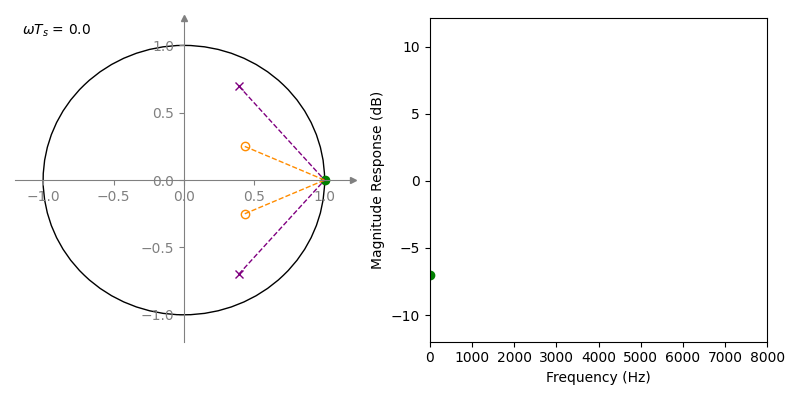

In [ ]:

# Feel free to change these pole-zero locations to see the impact! 
# Expressing poles/zeros in polar form, but you can use the cartesian form.
# You only need to insert one pole and one zero as the code will generate the complex conjugates.

rz, thetaz = [0.5, np.pi/6] 
z1_re, z1_im = [rz*np.cos(thetaz), rz*np.sin(thetaz)]

rp, thetap = [0.8, (2.7*np.pi)/8]
p1_re, p1_im = [rp*np.cos(thetap), rp*np.sin(thetap)]


# Parameter Set up
fs = 8000
Ts = 1/fs   # sampling period Ts
df = 10
freq_range = np.arange(0,fs,df)        # frequency range for analysis
omega_Ts_range = 2*np.pi*freq_range*Ts

xO,yO = (0,0)  # origin
UnitCircle = patches.Circle((0.0, 0.0), radius=1,edgecolor="black",facecolor="none")



# Pre-compute magnitude response
Mag_Resp = np.zeros(len(freq_range))

for n in np.arange(0,len(freq_range),1):
    omega_Ts = omega_Ts_range[n]

    # distance computations
    z1_dist = np.abs(np.exp(1j*omega_Ts)-rz*np.exp(1j*thetaz))
    z1conj_dist = np.abs(np.exp(1j*omega_Ts)-rz*np.exp(-1j*thetaz))
    p1_dist = np.abs(np.exp(1j*omega_Ts)-rp*np.exp(1j*thetap))
    p1conj_dist = np.abs(np.exp(1j*omega_Ts)-rp*np.exp(-1j*thetap))
    Mag_Resp[n] = 20*np.log10(((z1_dist)*(z1conj_dist))/((p1_dist)*(p1conj_dist)))


# PLOT
fig, axes = plt.subplots(1,2,figsize=(8,4))
pole_color = "purple"; zero_color = "darkorange"    

# # Unit Circle plot
axes[0].add_patch(UnitCircle) 
axes[0].set_xlim(-1.5,1.5)

# Poles + Zeros
axes[0].plot(p1_re, p1_im, 'x',color=pole_color)
axes[0].plot(p1_re, -p1_im, 'x', color=pole_color)
axes[0].plot(z1_re, z1_im, 'o', color = zero_color, fillstyle="none")
axes[0].plot(z1_re, -z1_im, 'o',color = zero_color, fillstyle="none")

# Frequency points + distances to poles/zeros
line_mainstem, = axes[0].plot([], [], 'k--',lw=1)
line_mainpt, = axes[0].plot([], [], 'g-o',lw=1)

dist_p1, = axes[0].plot([], [], '--',lw=1, color=pole_color)
dist_p1conj, = axes[0].plot([], [], '--',lw=1, color=pole_color)
dist_z1, = axes[0].plot([], [], '--',lw=1, color=zero_color)
dist_z1conj, = axes[0].plot([], [], '--',lw=1, color=zero_color)

time_text = axes[0].text(0.02, 0.95, '', transform=axes[0].transAxes)



#% Magnitude Plot
line_mag, = axes[1].plot([], [], 'green',lw=1)
line_magpt, = axes[1].plot([], [], 'green',marker='o',lw=1)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude Response (dB)')
axes[1].set_xlim(0,fs)
axes[1].set_ylim(np.min(Mag_Resp)-5, np.max(Mag_Resp)+5)

# Changing around the axes (formatting stuff)
axes[0].xaxis.set_ticks_position('bottom')
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.label.set_color('grey')
axes[0].tick_params(axis='x', colors='grey')
axes[0].yaxis.label.set_color('grey')
axes[0].tick_params(axis='y', colors='grey')

axes[0].spines['left'].set_position('zero')
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_position('zero')
axes[0].spines['top'].set_visible(False)

axes[0].spines['left'].set_color('grey')
axes[0].spines['bottom'].set_color('grey')

# make arrows
axes[0].plot((1), (0), ls="", marker=">", ms=5, color="grey", transform=axes[0].get_yaxis_transform(), clip_on=False)
axes[0].plot((0), (1), ls="", marker="^", ms=5, color="grey",transform=axes[0].get_xaxis_transform(), clip_on=False)
axes[0].set_xlim(-1.2, 1.2)
axes[0].set_ylim(-1.2, 1.2)
plt.tight_layout()


# Create the interactive plot
def update(freq = 0):

    idx = int(freq/df) # for plotting

    omega_Ts = 2*np.pi*freq*Ts
    time_text.set_text('$\omega T_s$ = '+str(np.round(omega_Ts,decimals=2)))

    
    # Unit circle point
    x = np.cos(omega_Ts)
    y = np.sin(omega_Ts)
    line_mainpt.set_data([x],[y])

    # Distances to poles/zeros
    dist_p1.set_data([p1_re, x],[p1_im, y])
    dist_p1conj.set_data([p1_re, x],[-p1_im, y])
    
    dist_z1.set_data([z1_re, x],[z1_im, y])
    dist_z1conj.set_data([z1_re, x],[-z1_im, y])

    
    line_mag.set_data(freq_range[:idx],Mag_Resp[:idx])    
    line_magpt.set_data([freq],[Mag_Resp[idx]]) 
    # line_mag.set_data(omega*t[0:i+1],Mag_Resp[0:i+1])    
    # line_magpt.set_data(omega*t[i],Mag_Resp[i])
    

print('Move the slider to evaluate the magnitude response for different frequencies (Hz)!')
print('Sampling Frequency = '+str(fs)+' Hz')
interact(update, freq = (0,fs-df,df)); 




### Biquadratic filters


Recall that the poles and zeros are, in general, complex-valued, and hence we can express them in terms of a magnitude and phase. Since filter coefficients ($a_k$ and $b_k$) are real-valued, the poles and zeros also appear in complex-conjugate pairs. Consequently, we can rewrite $q_1, q_2, p_1,$ and $p_2$ as follows:

$$
\begin{align}
q_1 &= r_z e^{j\theta_z}; q_2 = r_z e^{-j\theta_z} \nonumber \\
p_1 &= r_z e^{j\theta_z}; p_2 = r_z e^{-j\theta_z}
\end{align}
$$

where $r_z$ and $\pm \theta_z$ are the magnitude and phases of the zeros respectively, and $r_p$ and $\pm \theta_p$ are the magnitude and phases of the poles respectively. (Recall that $the complex conjugate of $e^{j\theta}$ is $e^{-j\theta}$ (you can prove using Euler's identity)).

Substituting $z=e^{j\omega T_s}$ and taking the magnitude to get the magnitude response results in:

$$
|H(e^{j\omega T_s})|  =  \frac{|(e^{j\omega T_s}- r_z e^{j\theta_z})| . |(e^{j\omega T_s}- r_z e^{-j\theta_z})|}{|(e^{j\omega T_s}- r_p e^{j\theta_p})| . |(e^{j\omega T_s}- r_p e^{-j\theta_p})|}\nonumber \\
$$

This expression already gives us a hint into this filter's frequency response by considering the lengths of vectors drawn from zeros to point $e^{j \omega T_s}$ and the lengths of vectors drawn from the poles to point $e^{j \omega T_s}$. For instance, when the term $|(e^{j\omega T_s}- r_p e^{j\theta_p})|$ 

#### The constrained biquad filter


Let us first recall the biquad filter in the $z$-domain without any constraints:

\begin{equation}
H(z^{-1}) = \frac{b_{o} + b_{1} z^{-1} + b_{2}z^{-2} }{1 + a_{1} z^{-1} + a_{2}z^{-2} }.
\end{equation}  

With $b_{o} = 1$, the biquad can be expressed in polar coordinates (in the complex plane) in terms of a zero radius, $\zeta$, and zero angle $\omega_{z}$, and a pole radius, $\rho$, and pole angle, $\omega_{p}$ as follows

$\begin{equation}
H(z^{-1}) = \frac{(1 - \zeta e^{j\omega_{z}}  z^{-1}) (1 - \zeta e^{-j\omega_{z}} z^{-1})  }{(1 - \rho e^{j\omega_{p}} z^{-1}) (1 - \rho e^{-j\omega_{p}} z^{-1})}
\end{equation}$  
where $b_{1}  = -(\zeta e^{j\omega_{z}} + \zeta e^{-j\omega_{z}}) = -2 \zeta \cos(\omega_{z})$,  $b_{2} = \zeta^{2}$, $a_{1}  =   -2 \rho \cos(\omega_{p})$,  and $a_{2} = \rho^{2}$. There are 4 parameters here that can be adjusted to configure the biquad in various ways. 





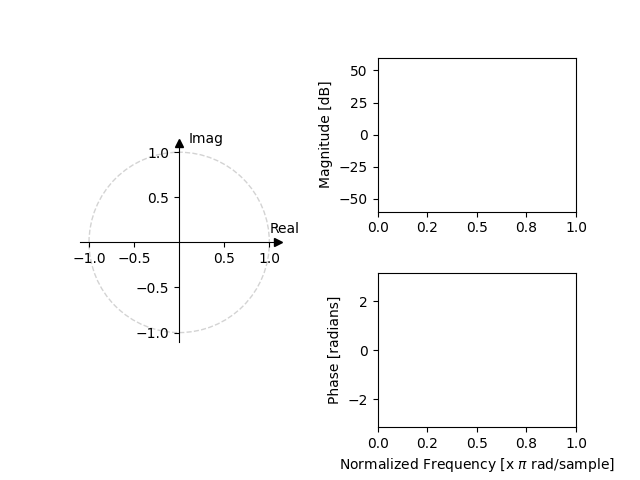

Move the slider to see how the filter changes with the positions of the poles and zeros!
Note that the omega parameter is the true value of omega in radians, but the x-axis of the Magnitude/Phase plots are normalized by $\pi$


interactive(children=(FloatSlider(value=0.8, description='rho', max=0.999, step=0.001), FloatSlider(value=0.95…

In [83]:
# Setting up the plots
fig, axes = plt.subplot_mosaic([["top left", "top centre"],["top left", "bottom centre"]])
plt.subplots_adjust(wspace=0.5,hspace=0.4)

# Create the unit circle
uc = patches.Circle((0,0), radius=1, fill=False, color='lightgray', ls='dashed')
axes["top left"].add_patch(uc)
 

# Plot the zeros and set marker properties    
t1, = axes["top left"].plot([], [], 'ko', ms=10)
plt.setp( t1, markersize=8.0, markeredgewidth=1.0,
          markeredgecolor='k', markerfacecolor='k')

# Plot the poles and set marker properties
t2, = axes["top left"].plot([], [], 'kx', ms=10)
plt.setp( t2, markersize=8.0, markeredgewidth=3.0,
          markeredgecolor='k', markerfacecolor='r')

axes["top left"].spines['left'].set_position('center')
axes["top left"].spines['bottom'].set_position('center')
axes["top left"].spines['right'].set_visible(False)
axes["top left"].spines['top'].set_visible(False)

axes["top left"].plot(1, 0, ">k", transform=axes["top left"].get_yaxis_transform(), clip_on=False)
axes["top left"].plot(0, 1, "^k", transform=axes["top left"].get_xaxis_transform(), clip_on=False)

# set the ticks
r = 1.1; 
axes["top left"].axis('scaled');
ticks_x = [-1, -0.5, 0.5, 1]; 
ticks_y = [-1, -0.5, 0.5, 1]; 
axes["top left"].set_xticks(ticks_x)
axes["top left"].set_yticks(ticks_y)
axes["top left"].text(1,0.1,'Real');
axes["top left"].text(0.1,1.1,'Imag');



lineMag, = axes["top centre"].plot([], [], 'k')
axes["top centre"].set_ylabel('Magnitude [dB]', color='k')
axes["top centre"].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes["top centre"].set_xlim([0, 1])
axes["top centre"].set_ylim([-60, 60])


# angles = np.unwrap(np.angle(h))
linePh, = axes["bottom centre"].plot([], [], 'k')
axes["bottom centre"].set_ylabel('Phase [radians]', color='k')
axes["bottom centre"].set_xlabel('Normalized Frequency [x $\pi$ rad/sample]')
axes["bottom centre"].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes["bottom centre"].set_ylim([-np.pi, np.pi])
axes["bottom centre"].set_xlim([0, 1])
# axes["bottom centre"].axis('tight')
plt.show()

# Create the interactive plot
def update(rho = 0.8, zeta = 0.95, omegaz=np.pi/4, omegap = np.pi/4):
    

    bo = 1;
    b1 = -2*np.cos(omegaz)*zeta;
    b2 = zeta**2;

    a1 = -2*np.cos(omegap)*rho;
    a2 = rho**2;

    b = [bo,b1,b2];
    a = [1,a1,a2];

    # FREQZ to get magnitude and phase
    w, h = signal.freqz(b,a)
    Mag = 20 * np.log10(abs(h))
    freq_axis = w/np.pi
    angles = np.unwrap(np.angle(h))
    
    # Get the poles and zeros
    p = np.roots(a)
    z = np.roots(b)


    lineMag.set_data(freq_axis, Mag)
    linePh.set_data(freq_axis, angles)
    t1.set_data(z.real, z.imag)
    t2.set_data(p.real, p.imag)

print('Move the slider to see how the filter changes with the positions of the poles and zeros!')
print('Note that the omega parameter is the true value of omega in radians, but the x-axis of the Magnitude/Phase plots are normalized by $\pi$')
interact(update, rho = (0,0.999,0.001), zeta = (0,0.999,0.001), omegaz=(0,np.pi,np.pi/16), omegap=(0,np.pi,np.pi/16)); 



We can impose the following constraint to configure a notch/resonant filter:

1. The poles and zeros need to lie on the same radial line, defined by angle $\omega$ in the complex plane, i.e. $\omega_{z} = \omega_{p} = \omega$. 

Let's check out an animation to see what kind of filters we can get.

<!--These poles and zeros must also lie completely within the unit circle, where the zeros would be in between the poles and the unit circle in order to define a notch filter. 

However, it would be more efficient if we can somehow reduce this to just one parameter, which can be updated by means of some adaptive filter. Hence in order to convert this 4-parameter biquad into a single parameter biquad that acts as a notch filter, two constraints need to be imposed:

1. The poles and zeros need to lie on the same radial line, defined by angle $\omega$ in the complex plane, i.e. $\omega_{z} = \omega_{p} = \omega$. These poles and zeros must also lie completely within the unit circle, where the zeros would be in between the poles and the unit circle in order to define a notch filter. 


2. The zeros all need to lie on the unit circle so that $\zeta = 1$. In this case the frequency component at $\omega$ would be completely attenuated and the pole at the same radial line would once again create a resonance at $\omega$, with the bandwidth of the notch filter becoming narrower as $\rho \rightarrow 1$ .-->

<!-- \begin{figure}
	\centering
	\includegraphics[width=\linewidth]{figs/bode_plots_biquad_edit}
	\caption{(Left) Pole-zero plot of a constrained biquad IIR filter configured as a notch filter. The poles and zeros lie on the same radial line defined by $\omega = \pi/4$, where the zeros are placed on the unit circle and the poles at a distance $\rho = 0.8$. (Right) The corresponding magnitude and phase response. A notch is clearly visible at $\omega = \pi/4$ with a very narrow bandwidth due to $\rho = 0.8$. }
	\label{fig:bodeplotsbiquadedit}
\end{figure} -->


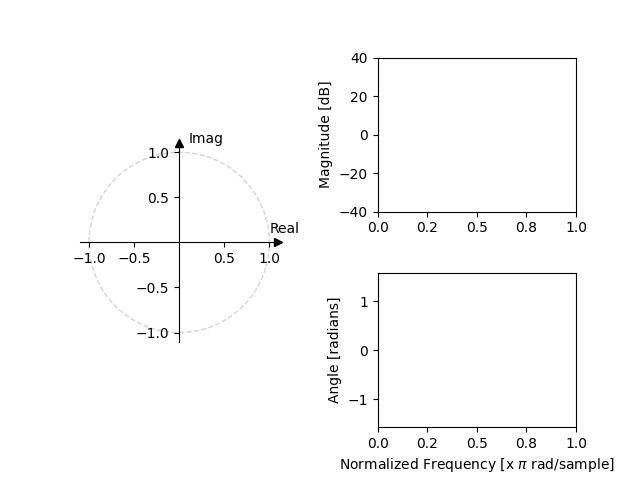

Move the slider to see how the filter changes with the pole radius and centre frequency!
Note that the omega parameter is the true value of omega in radians, but the x-axis of the Magnitude/Phase plots are normalized by $\pi$


interactive(children=(FloatSlider(value=0.8, description='rho', max=0.95, step=0.01), FloatSlider(value=0.4, d…

In [85]:
# Setting up the plots
fig, axes = plt.subplot_mosaic([["top left", "top centre"],["top left", "bottom centre"]])
plt.subplots_adjust(wspace=0.5,hspace=0.4)

# Create the unit circle
uc = patches.Circle((0,0), radius=1, fill=False, color='lightgray', ls='dashed')
axes["top left"].add_patch(uc)
 

# Plot the zeros and set marker properties    
t1, = axes["top left"].plot([], [], 'ko', ms=10)
plt.setp( t1, markersize=8.0, markeredgewidth=1.0,
          markeredgecolor='k', markerfacecolor='k')

# Plot the poles and set marker properties
t2, = axes["top left"].plot([], [], 'kx', ms=10)
plt.setp( t2, markersize=8.0, markeredgewidth=3.0,
          markeredgecolor='k', markerfacecolor='r')

axes["top left"].spines['left'].set_position('center')
axes["top left"].spines['bottom'].set_position('center')
axes["top left"].spines['right'].set_visible(False)
axes["top left"].spines['top'].set_visible(False)

axes["top left"].plot(1, 0, ">k", transform=axes["top left"].get_yaxis_transform(), clip_on=False)
axes["top left"].plot(0, 1, "^k", transform=axes["top left"].get_xaxis_transform(), clip_on=False)

# set the ticks
r = 1.1; 
axes["top left"].axis('scaled');
ticks_x = [-1, -0.5, 0.5, 1]; 
ticks_y = [-1, -0.5, 0.5, 1]; 
axes["top left"].set_xticks(ticks_x)
axes["top left"].set_yticks(ticks_y)
axes["top left"].text(1,0.1,'Real');
axes["top left"].text(0.1,1.1,'Imag');



lineMag, = axes["top centre"].plot([], [], 'k')
axes["top centre"].set_ylabel('Magnitude [dB]', color='k')
axes["top centre"].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes["top centre"].set_xlim([0, 1])
axes["top centre"].set_ylim([-40, 40])


# angles = np.unwrap(np.angle(h))
linePh, = axes["bottom centre"].plot([], [], 'k')
axes["bottom centre"].set_ylabel('Angle [radians]', color='k')
axes["bottom centre"].set_xlabel('Normalized Frequency [x $\pi$ rad/sample]')
axes["bottom centre"].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes["bottom centre"].set_ylim([-np.pi/2, np.pi/2])
axes["bottom centre"].set_xlim([0, 1])
# axes["bottom centre"].axis('tight')
plt.show()

# Create the interactive plot
def update(rho = 0.8, zeta = 0.4, omega=np.pi/4):
    
    fig.canvas.draw_idle()
    
    b1 = -2*zeta*np.cos(omega)
    b2 = zeta**2
    a1 = -2*rho*np.cos(omega)
    a2 = rho**2
    bo = 1; ao = 1;

    b =[bo,b1,b2]
    a =[ao, a1, a2]
    

    # FREQZ to get magnitude and phase
    w, h = signal.freqz(b,a)
    Mag = 20 * np.log10(abs(h))
    freq_axis = w/np.pi
    angles = np.unwrap(np.angle(h))
    
    # Get the poles and zeros
    p = np.roots(a)
    z = np.roots(b)


    lineMag.set_data(freq_axis, Mag)
    linePh.set_data(freq_axis, angles)
    t1.set_data(z.real, z.imag)
    t2.set_data(p.real, p.imag)

print('Move the slider to see how the filter changes with the pole radius and centre frequency!')
print('Note that the omega parameter is the true value of omega in radians, but the x-axis of the Magnitude/Phase plots are normalized by $\pi$')
interact(update, rho = (0,0.95,0.01), zeta = (0,0.95,0.01), omega=(0,np.pi,np.pi/16)); 

